## Toy example: cs learning



In [85]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



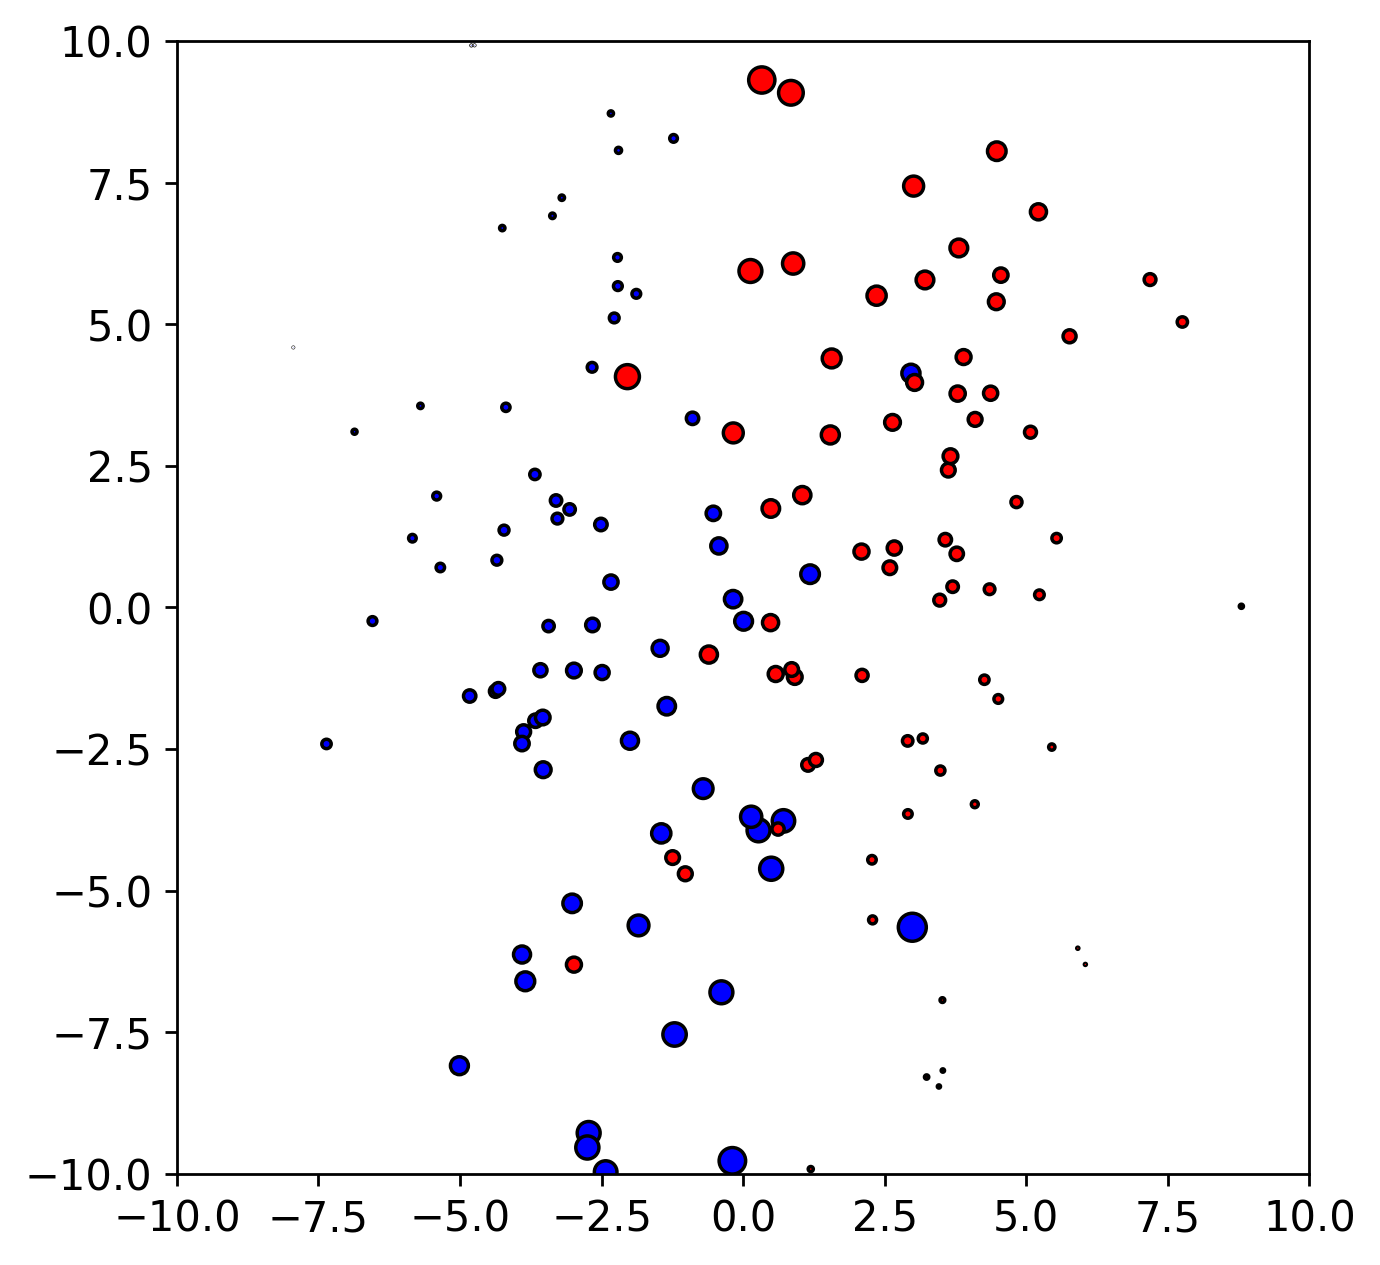

In [86]:
# Create data
sample_n = 75
noise_factor = 2.5

np.random.seed(10)

x1_neg = -3 + noise_factor * np.random.standard_normal(sample_n)
x2_neg = 0 + noise_factor * np.random.standard_normal(sample_n) * 2
x_neg = np.transpose([x1_neg, x2_neg])
cost_neg = (3*x1_neg - 2*x2_neg + 1*np.random.standard_normal(sample_n))
cost_neg = (cost_neg + np.abs(cost_neg.min()))**2 / 50
labels_neg = np.zeros(sample_n)

x1_pos = 3 + noise_factor * np.random.standard_normal(sample_n)
x2_pos = 0 + noise_factor * np.random.standard_normal(sample_n) * 2
x_pos = np.transpose([x1_pos, x2_pos])
cost_pos = (-3*x1_pos + 2*x2_pos + 1*np.random.standard_normal(sample_n))
cost_pos = (cost_pos + np.abs(cost_pos.min()))**2 / 50
labels_pos = np.ones(sample_n)

x = np.concatenate((x_neg, x_pos))
labels = np.concatenate((labels_neg, labels_pos))
costs = np.concatenate((cost_neg, cost_pos))

# Visualize
fig, ax = plt.subplots()
ax.scatter(x_neg[:,0], x_neg[:,1], color='blue', s=cost_neg, edgecolors='k')
ax.scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')
#ax.axhline(y=0, color='grey')
#ax.axvline(x=0, color='grey')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
fig.gca().set_aspect('equal', adjustable='box')

In [87]:
# Fit cost-insensitive model
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l1', solver='saga', random_state=0, C=100000)

logit.fit(x, labels)

print(logit.coef_)

# Fit cost-sensitive model

from methodologies.cs_logit import cs_logit
init_theta = np.insert(logit.coef_, 0, values=logit.intercept_)
cslogit = cs_logit.CSLogit(lambda1=0.1, fixed_cost=costs, obj='weightedce', initial_theta=init_theta)
cslogit.fitting(x, labels, costs)

print(cslogit.theta)

[[1.07574296 0.02363271]]
[-0.17542287  0.47645999  0.23950004]


0.02444028641352386
0.9755597135864762


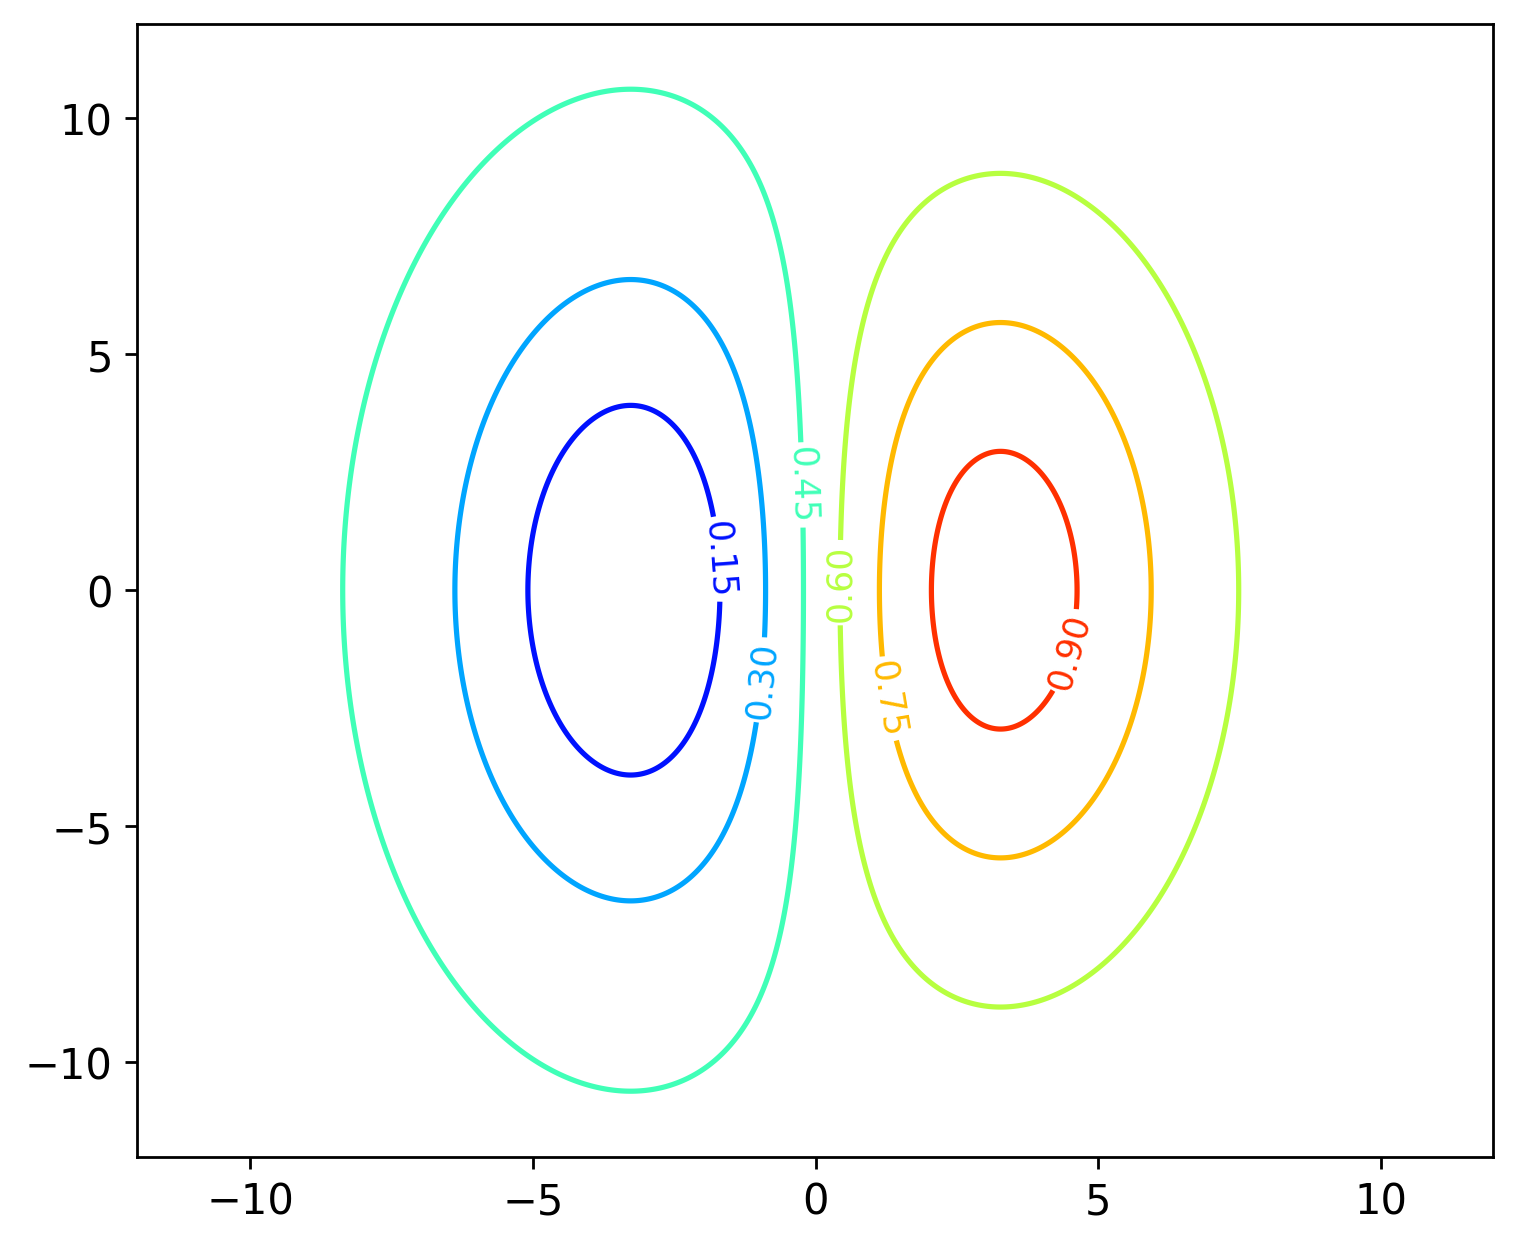

In [88]:
# Create grid to iterate over
grid_size = 12

grid_x1, grid_x2 = np.meshgrid(np.arange(-grid_size, grid_size, 0.01), np.arange(-grid_size, grid_size, 0.01))

grid = np.transpose(np.array([grid_x1.flatten(), grid_x2.flatten()]))

# True distributions
from scipy.stats import multivariate_normal
dist_neg = (1 / 2*np.pi) * np.exp(- 0.5 * ((grid-3)**2 + grid**2))
dist_pos = (1 / 2*np.pi) * np.exp(- 0.5 * ((grid+3)**2 + grid**2))
dist = - dist_neg + dist_pos

sig = noise_factor**2
dist_neg = multivariate_normal(mean=[-3,0], cov=[[sig, 0], [0, sig*4]])
dist_neg_samples = dist_neg.pdf(grid)
dist_neg_samples = np.reshape(dist_neg_samples, grid_x1.shape) / dist_neg_samples.max()
dist_pos = multivariate_normal(mean=[3,0], cov=[[sig, 0], [0, sig*4]])
dist_pos_samples = dist_pos.pdf(grid)
dist_pos_samples = np.reshape(dist_pos_samples, grid_x1.shape) / dist_pos_samples.max()
dist = (- dist_neg_samples + dist_pos_samples) / 2 + 0.5

print(dist.min())
print(dist.max())

dist = np.clip(dist, 0, 1)
cntr = plt.contour(grid_x1, grid_x2, dist, cmap='jet')
plt.clabel(cntr, inline_spacing=1, fmt='%.2f', fontsize=10)

# Logit
probas_logit = logit.predict_proba(grid)[:, 1]
probas_logit = np.reshape(probas_logit, grid_x1.shape)

# CS Logit
probas_cslogit, _ = cslogit.predictcslogit(grid, threshold=0.5)
probas_cslogit = np.reshape(probas_cslogit, grid_x1.shape)


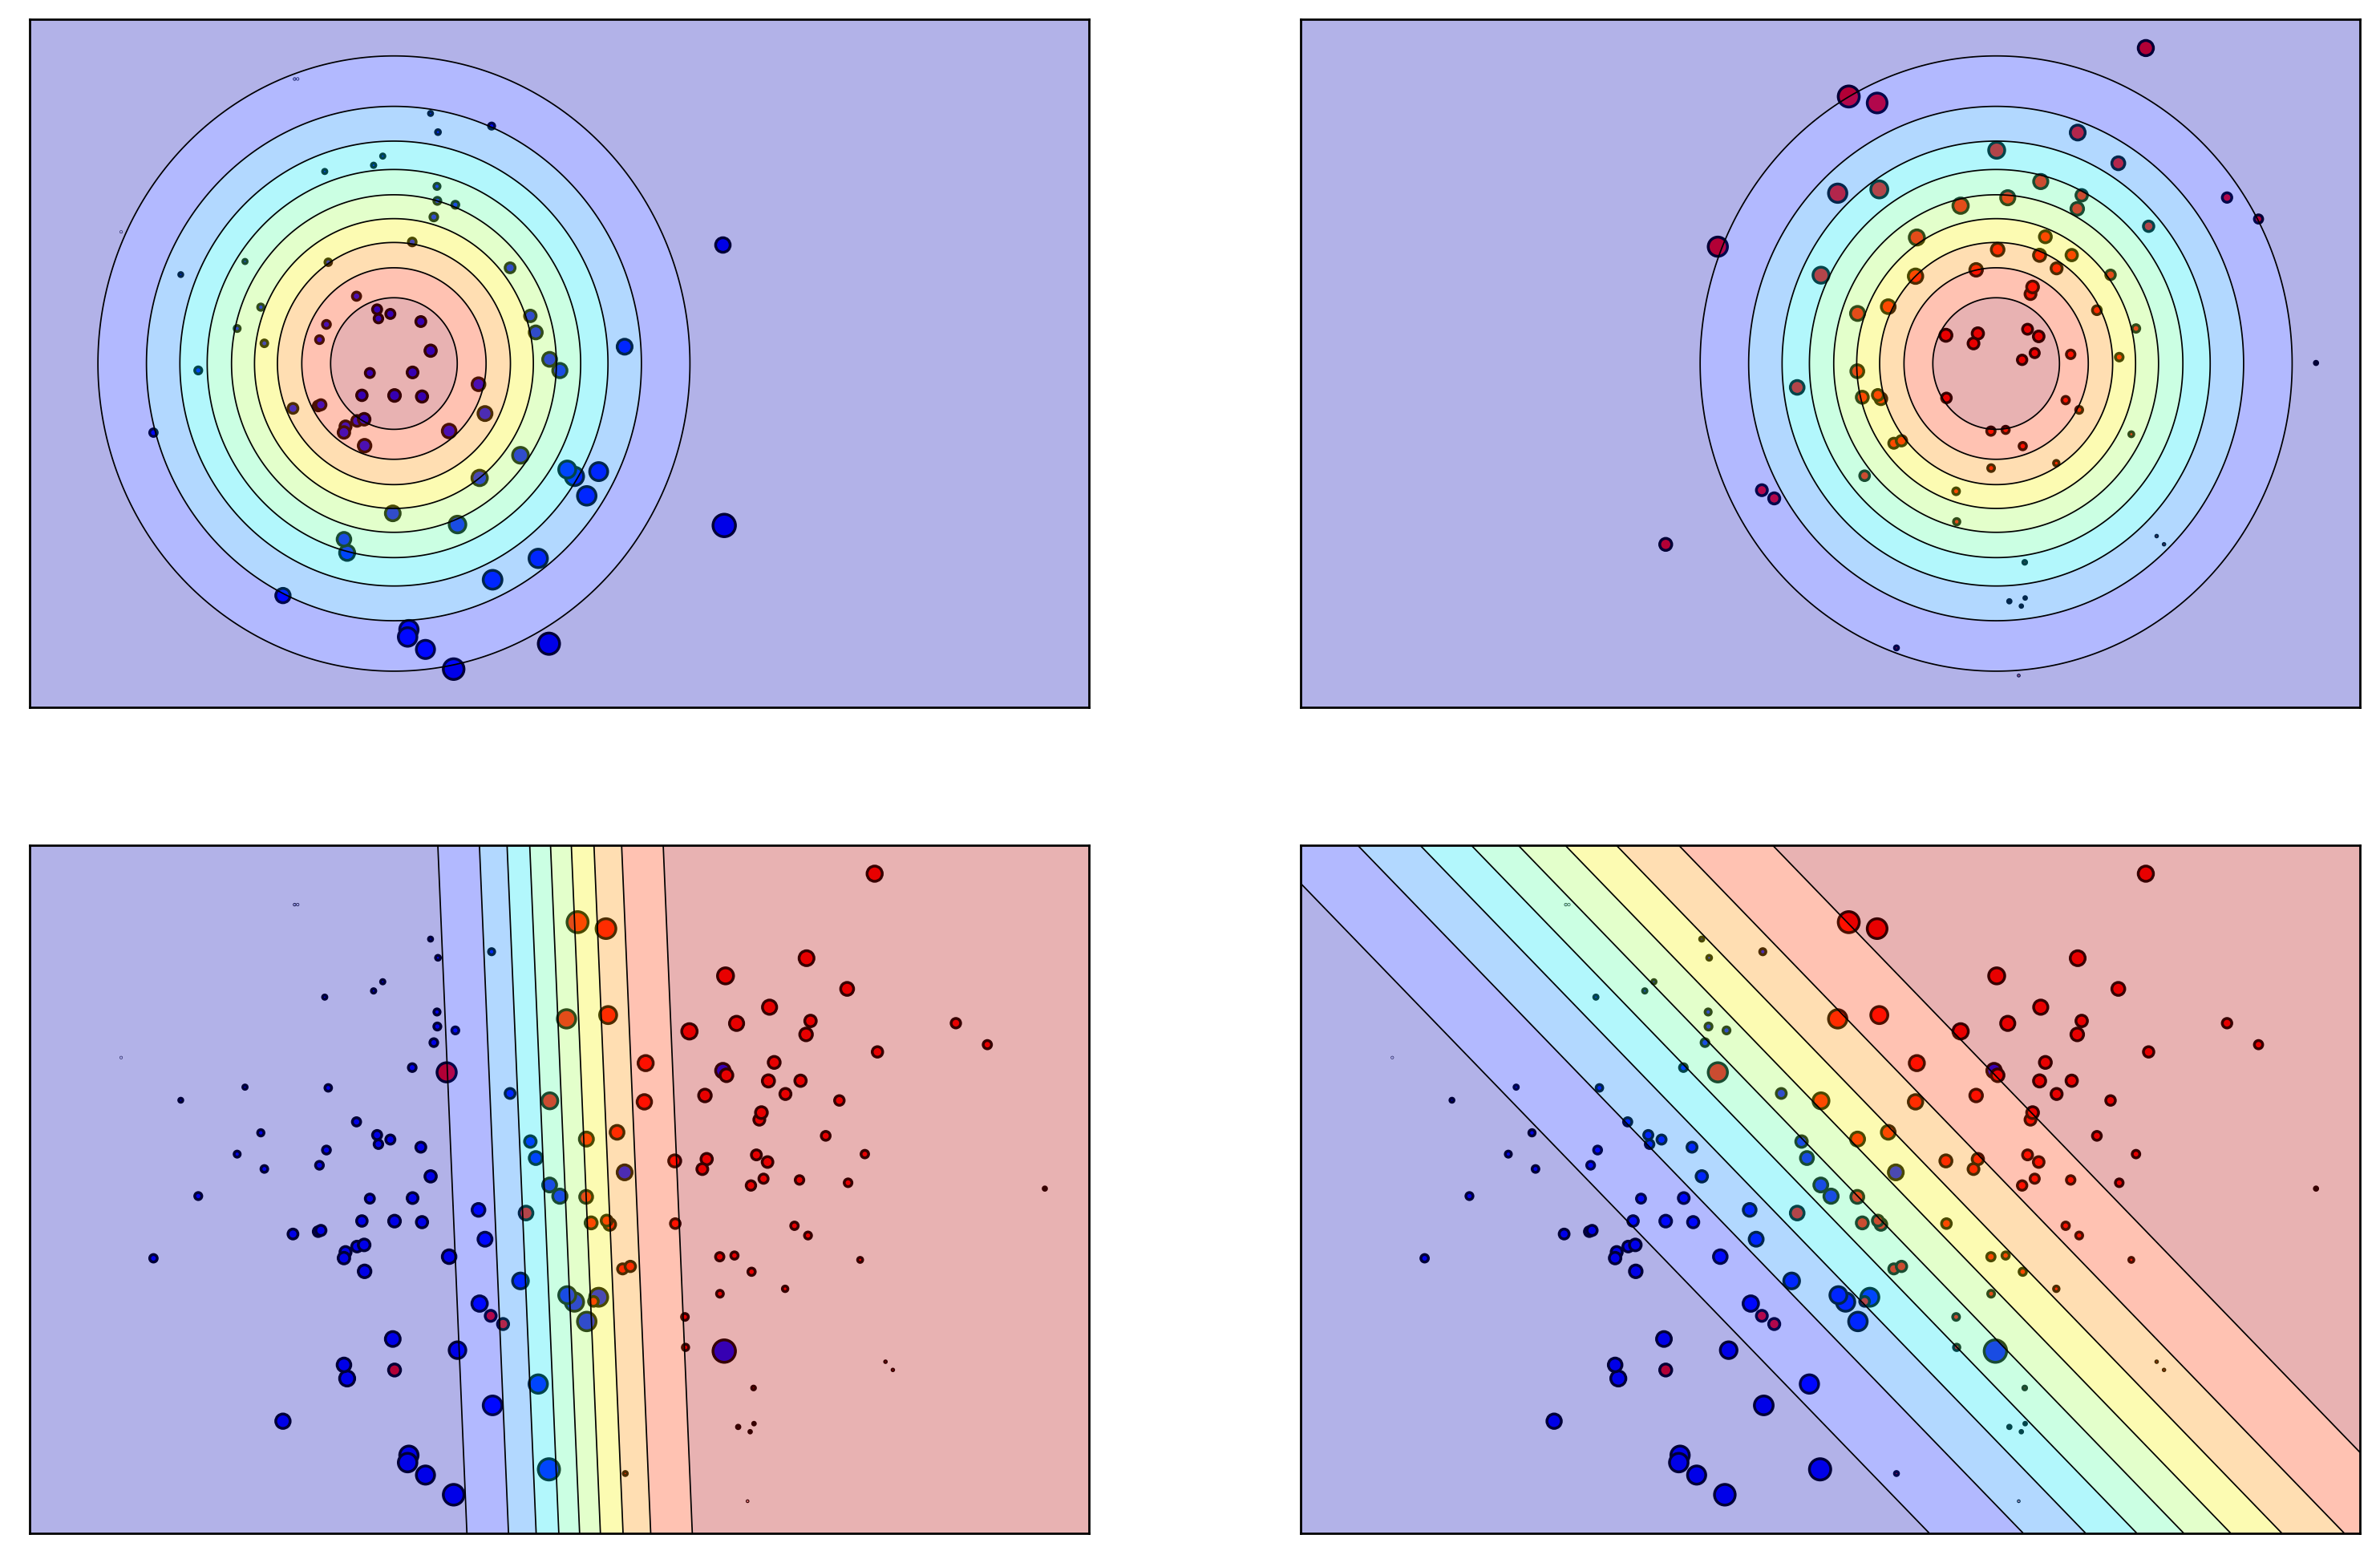

In [89]:
# Visualize
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 10)
ax[0,0].scatter(x_neg[:,0], x_neg[:,1], marker='o', color='blue', s=cost_neg, edgecolors='k')
#ax[0,0].scatter(x_pos[:,0], x_pos[:,1], marker='o', color='red', s=cost_pos, edgecolors='k')
#ax[0,1].scatter(x_neg[:,0], x_neg[:,1], color='blue', s=cost_neg, edgecolors='k')
ax[0,1].scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')
ax[1,0].scatter(x_neg[:,0], x_neg[:,1], color='blue', s=cost_neg, edgecolors='k')
ax[1,0].scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')
ax[1,1].scatter(x_neg[:,0], x_neg[:,1], color='blue', s=cost_neg, edgecolors='k')
ax[1,1].scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')

# Distributions
#ax.figure('Contour', facecolor='white')
cntr0 = ax[0,0].contour(grid_x1, grid_x2, dist_neg_samples, colors='black', linewidths=0.5, levels=np.arange(0,1.1,0.1))
#ax[0,0].clabel(cntr0, inline_spacing=1, fmt='%.2f', fontsize=10)
ax[0,0].contourf(grid_x1, grid_x2, dist_neg_samples, alpha=0.3, cmap='jet', levels=np.arange(0,1.1,0.1))
cntr01 = ax[0,1].contour(grid_x1, grid_x2, dist_pos_samples, colors='black', linewidths=0.5, levels=np.arange(0,1.1,0.1))
#ax[0,0].clabel(cntr01, inline_spacing=1, fmt='%.2f', fontsize=10)
ax[0,1].contourf(grid_x1, grid_x2, dist_pos_samples, alpha=0.3, cmap='jet', levels=np.arange(0,1.1,0.1))

# Classifiers
cntr1 = ax[1,0].contour(grid_x1, grid_x2, probas_logit, colors='black', linewidths=0.5, levels=np.arange(0,1.1,0.1))
#ax[1,0].clabel(cntr1, inline_spacing=1, fmt='%.2f', fontsize=10)
ax[1,0].contourf(grid_x1, grid_x2, probas_logit, alpha=0.3, cmap='jet', levels=np.arange(0,1.1,0.1))
cntr2 = ax[1,1].contour(grid_x1, grid_x2, probas_cslogit, colors='black', linewidths=0.5, levels=np.arange(0,1.1,0.1))
#ax[1,1].clabel(cntr2, inline_spacing=1, fmt='%.2f', fontsize=10)
ax[1,1].contourf(grid_x1, grid_x2, probas_cslogit, alpha=0.3, cmap='jet', levels=np.arange(0,1.1,0.1))

ax[0,0].set_xlim([-grid_size*0.8, grid_size*0.8])
ax[0,0].set_ylim([-grid_size, grid_size])
ax[0,1].set_xlim([-grid_size*0.8, grid_size*0.8])
ax[0,1].set_ylim([-grid_size, grid_size])
ax[1,0].set_xlim([-grid_size*0.8, grid_size*0.8])
ax[1,0].set_ylim([-grid_size, grid_size])
ax[1,1].set_xlim([-grid_size*0.8, grid_size*0.8])
ax[1,1].set_ylim([-grid_size, grid_size])

ax[0,0].axes.get_xaxis().set_visible(False)
ax[0,0].axes.get_yaxis().set_visible(False)
ax[0,1].axes.get_xaxis().set_visible(False)
ax[0,1].axes.get_yaxis().set_visible(False)
ax[1,0].axes.get_xaxis().set_visible(False)
ax[1,0].axes.get_yaxis().set_visible(False)
ax[1,1].axes.get_xaxis().set_visible(False)
ax[1,1].axes.get_yaxis().set_visible(False)

ax[0,0].patch.set_edgecolor('black')
ax[0,1].patch.set_edgecolor('black')
ax[1,0].patch.set_edgecolor('black')
ax[1,1].patch.set_edgecolor('black')

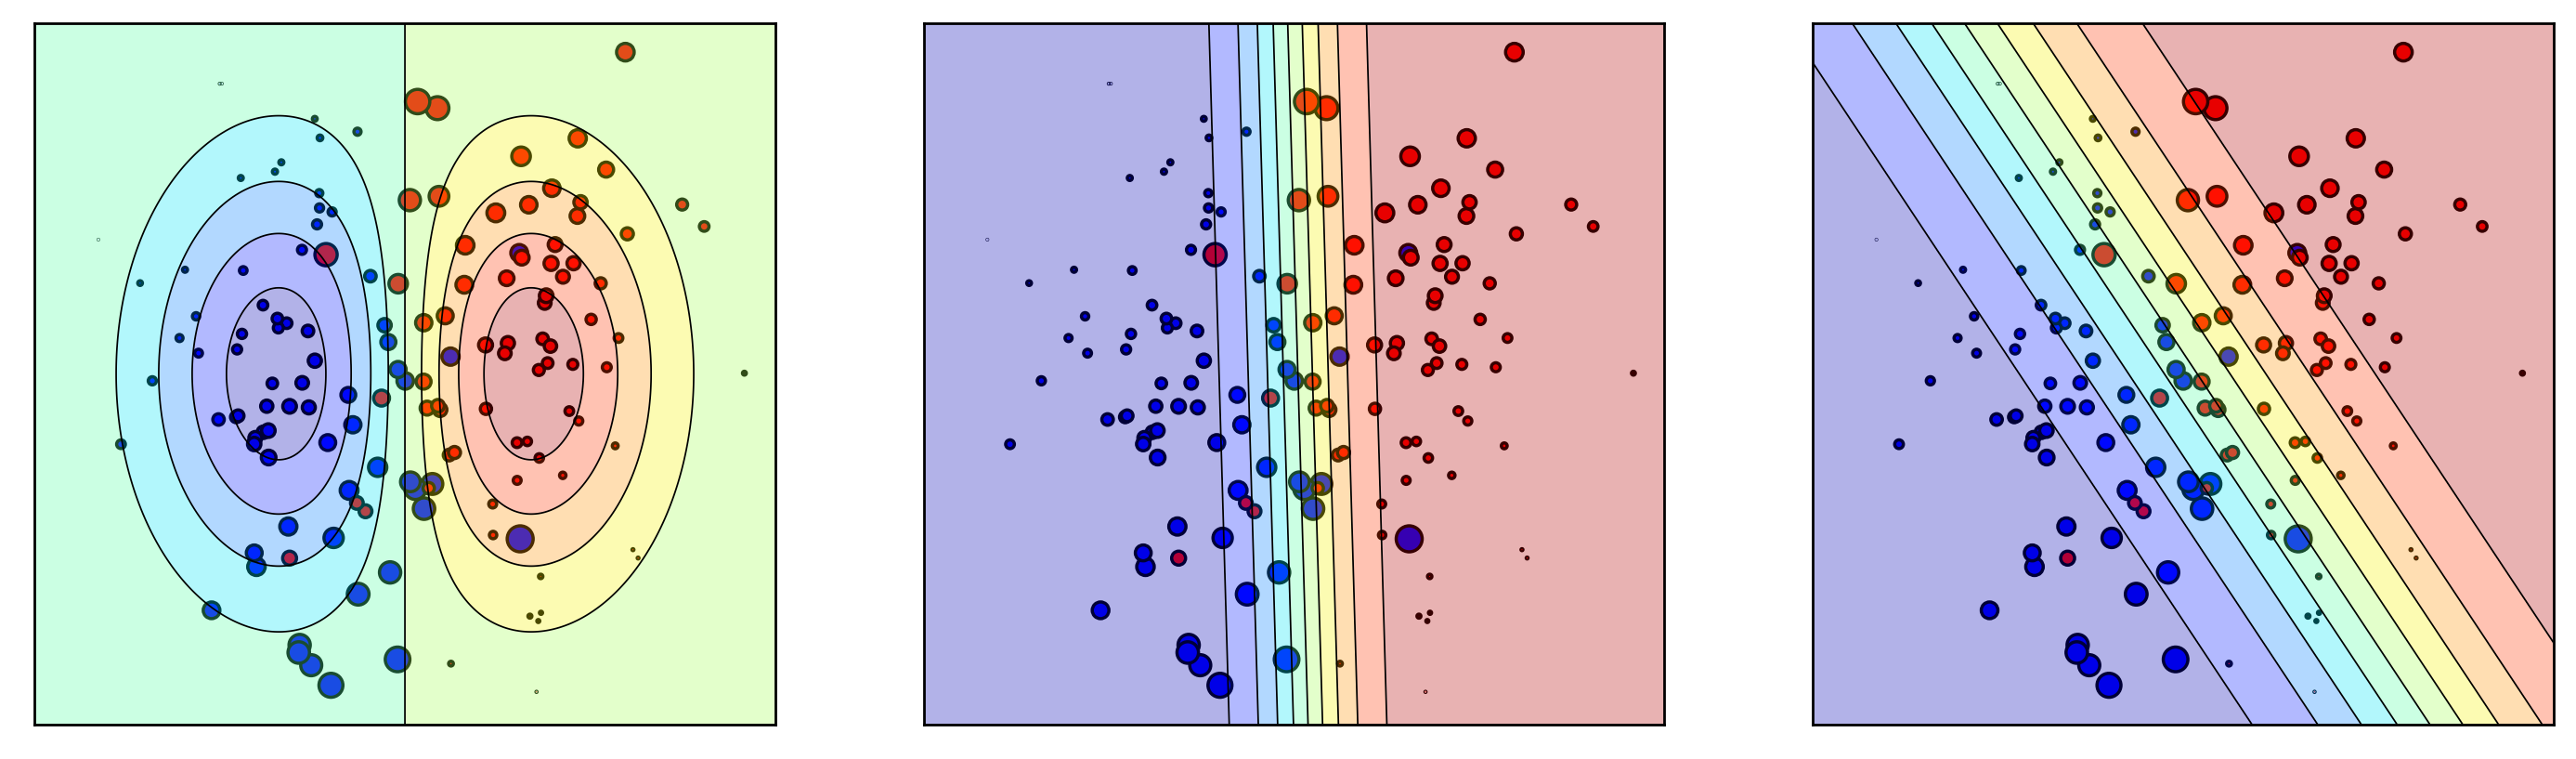

In [90]:
# Visualize
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(14, 4)
ax[0].scatter(x_neg[:,0], x_neg[:,1], marker='o', color='blue', s=cost_neg, edgecolors='k')
#ax[0,0].scatter(x_pos[:,0], x_pos[:,1], marker='o', color='red', s=cost_pos, edgecolors='k')
#ax[0,1].scatter(x_neg[:,0], x_neg[:,1], color='blue', s=cost_neg, edgecolors='k')
ax[0].scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')
ax[1].scatter(x_neg[:,0], x_neg[:,1], color='blue', s=cost_neg, edgecolors='k')
ax[1].scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')
ax[2].scatter(x_neg[:,0], x_neg[:,1], color='blue', s=cost_neg, edgecolors='k')
ax[2].scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')

# Distributions
#ax.figure('Contour', facecolor='white')
cntr0 = ax[0].contour(grid_x1, grid_x2, dist, colors='black', linewidths=0.5, levels=np.arange(0,1.1,0.1))
#ax[0,0].clabel(cntr0, inline_spacing=1, fmt='%.2f', fontsize=10)
ax[0].contourf(grid_x1, grid_x2, dist, alpha=0.3, cmap='jet', levels=np.arange(0,1.1,0.1))

# Classifiers
cntr1 = ax[1].contour(grid_x1, grid_x2, probas_logit, colors='black', linewidths=0.5, levels=np.arange(0,1.1,0.1))
#ax[1,0].clabel(cntr1, inline_spacing=1, fmt='%.2f', fontsize=10)
ax[1].contourf(grid_x1, grid_x2, probas_logit, alpha=0.3, cmap='jet', levels=np.arange(0,1.1,0.1))
cntr2 = ax[2].contour(grid_x1, grid_x2, probas_cslogit, colors='black', linewidths=0.5, levels=np.arange(0,1.1,0.1))
#ax[1,1].clabel(cntr2, inline_spacing=1, fmt='%.2f', fontsize=10)
ax[2].contourf(grid_x1, grid_x2, probas_cslogit, alpha=0.3, cmap='jet', levels=np.arange(0,1.1,0.1))

ax[0].set_xlim([-grid_size*0.8, grid_size*0.8])
ax[0].set_ylim([-grid_size, grid_size])
ax[1].set_xlim([-grid_size*0.8, grid_size*0.8])
ax[1].set_ylim([-grid_size, grid_size])
ax[2].set_xlim([-grid_size*0.8, grid_size*0.8])
ax[2].set_ylim([-grid_size, grid_size])

ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)
ax[2].axes.get_xaxis().set_visible(False)
ax[2].axes.get_yaxis().set_visible(False)

ax[0].patch.set_edgecolor('black')
ax[1].patch.set_edgecolor('black')
ax[2].patch.set_edgecolor('black')

plt.savefig('Toy_example.pdf')

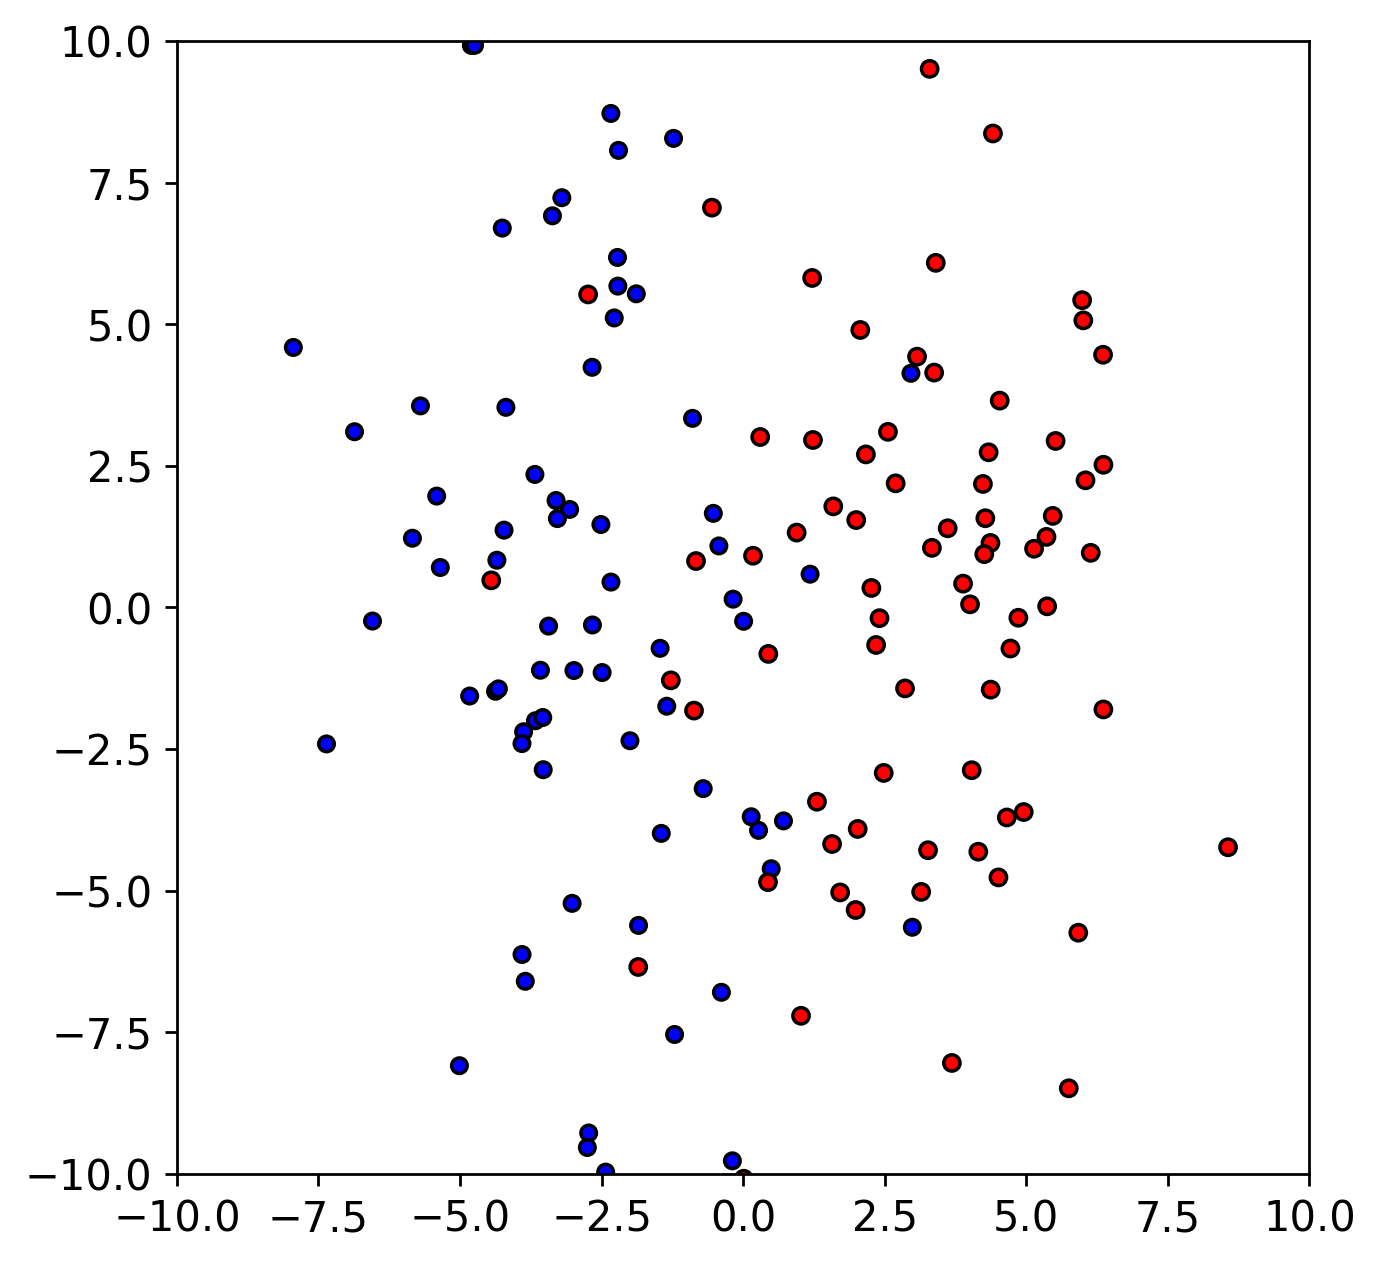

In [91]:
# Class-dependent costs

sample_n = 75
noise_factor = 2.5

np.random.seed(10)

x1_neg = -3 + noise_factor * np.random.standard_normal(sample_n)
x2_neg = 0 + noise_factor * np.random.standard_normal(sample_n) * 2
x_neg = np.transpose([x1_neg, x2_neg])
labels_neg = np.zeros(sample_n)

x1_pos = 3 + noise_factor * np.random.standard_normal(sample_n)
x2_pos = 0 + noise_factor * np.random.standard_normal(sample_n) * 2
x_pos = np.transpose([x1_pos, x2_pos])
labels_pos = np.ones(sample_n)

x = np.concatenate((x_neg, x_pos))
labels = np.concatenate((labels_neg, labels_pos))

cost_neg = 20*np.ones(sample_n)
cost_pos = 22*np.ones(sample_n)

costs = np.concatenate((cost_neg, cost_pos))

# Visualize
fig, ax = plt.subplots()
ax.scatter(x_neg[:,0], x_neg[:,1], color='blue', s=cost_neg, edgecolors='k')
ax.scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')
#ax.axhline(y=0, color='grey')
#ax.axvline(x=0, color='grey')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
fig.gca().set_aspect('equal', adjustable='box')

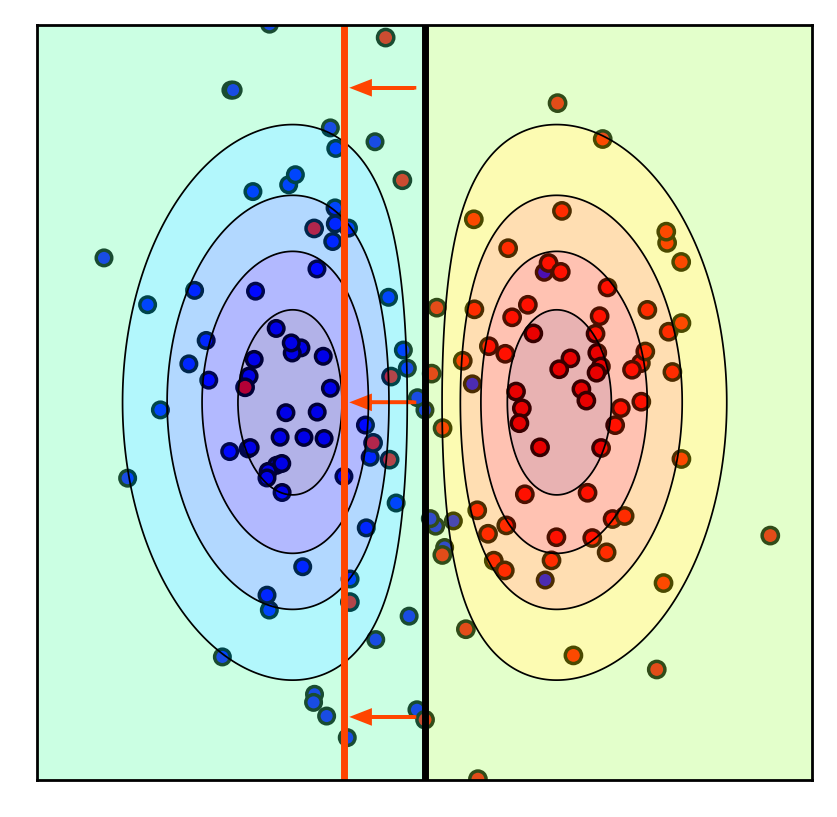

In [101]:
# Decision boundaries
# Logit
probas_logit = logit.predict_proba(grid)[:, 1]
probas_logit = np.reshape(probas_logit, grid_x1.shape)

# CS Logit
probas_cslogit, _ = cslogit.predictcslogit(grid, threshold=0.5)
probas_cslogit = np.reshape(probas_cslogit, grid_x1.shape)

# Visualize
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.scatter(x_neg[:,0], x_neg[:,1], marker='o', color='blue', s=cost_neg, edgecolors='k')
ax.scatter(x_pos[:,0], x_pos[:,1], color='red', s=cost_pos, edgecolors='k')

# Add "decision boundaries"
ax.axline((0, -12), (0, 12), c='k', mec='k', linewidth=2)
ax.axline((-2, -12), (-2, 12), c='orangered', linewidth=2)

ax.arrow(x=-0.25, y=10, dx=-1.5, dy=0, length_includes_head=True, head_width=0.4, head_length=0.4, color='orangered')
ax.arrow(x=-0.25, y=0, dx=-1.5, dy=0, length_includes_head=True, head_width=0.4, head_length=0.4, color='orangered')
ax.arrow(x=-0.25, y=-10, dx=-1.5, dy=0, length_includes_head=True, head_width=0.4, head_length=0.4, color='orangered')


cntr0 = ax.contour(grid_x1, grid_x2, dist, colors='black', linewidths=0.5, levels=np.arange(0,1.1,0.1))
ax.contourf(grid_x1, grid_x2, dist, alpha=0.3, cmap='jet', levels=np.arange(0,1.1,0.1))

ax.set_xlim([-grid_size*0.8, grid_size*0.8])
ax.set_ylim([-grid_size, grid_size])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.patch.set_edgecolor('black')

plt.savefig('toy_example_class_dependent_decision_boundary.png', bbox_inches='tight')